In [1]:

import utils
from scripts import get_activations, plot_3d_pca, get_accuracy
import copy
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

import importlib

importlib.reload(utils)
importlib.reload(get_activations)
importlib.reload(plot_3d_pca)
importlib.reload(get_accuracy)

<module 'scripts.get_accuracy' from '/n/home01/ajyl/ICLR_ICLR/scripts/get_accuracy.py'>

In [2]:

default_config = get_activations.get_default_config()
default_config

{'exp_dir': None,
 'overwrite': False,
 'model_params': {'model_name': 'meta-llama/Meta-Llama-3.1-8B',
  'rand_init': False,
  'nnsight': False,
  'remote': False},
 'dgp_params': {'graph_type': 'grid',
  'graph_size': 16,
  'self_edge': False,
  'separator': None,
  'sampling_kwargs': {'batch_size': 16,
   'uniform_init': False,
   'method': 'traverse',
   'n_examples': 1200},
  'sampling_seed': 42,
  'word_file_path': './words.txt',
  'word_seed': 42,
  'words': None},
 'record_params': {'layers_to_save': [0], 'nnsight': False, 'remote': False}}

In [3]:

tokens = np.loadtxt("./random_tokens.txt", dtype=str)
tokens = [" " + word for word in tokens]
tokens

[' apple',
 ' bird',
 ' car',
 ' egg',
 ' house',
 ' milk',
 ' plane',
 ' opera',
 ' box',
 ' sand',
 ' sun',
 ' mango',
 ' rock',
 ' math',
 ' code',
 ' phone',
 ' tree',
 ' dog',
 ' metal',
 ' water',
 ' fire',
 ' boat',
 ' mouse',
 ' cup',
 ' book',
 ' paper',
 ' key',
 ' tea',
 ' shoe',
 ' ball']

In [11]:

model = None
nnsight = False
remote = False

seed = 0
graph = "ring"
graph_size = 10
n_examples = 1200

wordsel = "16_tokens"
single_context = False
method = "random"
separator = "/"

if method == "random":
    if separator is not None:
        n_examples = int(n_examples / 3)
    else:
        n_examples = int(n_examples / 2)

if single_context:
    batch_size = 1
    bathced_ = "single"
    uniform_init = False
else:
    batch_size = graph_size
    bathced_ = "batch"
    uniform_init = True

if method == "random":
    separators = [None, "/"]

if separator is not None:
    separator_ = "sep"
else:
    separator_ = "nosep"

config = copy.deepcopy(default_config)


model_family = "llama"
model_size = "8B"
if model_family == "llama":
    if model_size == "8B":
        model_name = "meta-llama/Meta-Llama-3.1-8B"
        layers_to_save = list(range(0, 32, 2))
    elif model_size == "1B":
        model_name = "meta-llama/Llama-3.2-1B"
        layers_to_save = list(range(0, 16, 1))
    elif model_size == "70B":
        model_name = "meta-llama/Meta-Llama-3.1-70B"
        layers_to_save = list(range(0, 80, 5))

config["overwrite"] = True
config["model_params"]["model_name"] = model_name
config["model_params"]["nnsight"] = nnsight
config["model_params"]["remote"] = remote
config["record_params"]["nnsight"] = nnsight
config["record_params"]["remote"] = remote
config["record_params"]["get_logits"] = True
config["dgp_params"]["graph_type"] = graph
config["dgp_params"]["graph_size"] = graph_size
config["dgp_params"]["sampling_kwargs"]["batch_size"] = batch_size
config["dgp_params"]["sampling_kwargs"]["method"] = method
config["dgp_params"]["sampling_kwargs"]["n_examples"] = n_examples
config["dgp_params"]["sampling_kwargs"]["uniform_init"] = uniform_init
config["dgp_params"]["separator"] = separator
config["dgp_params"]["sampling_seed"] = seed
config["dgp_params"]["word_seed"] = seed

base_dir = f"./results/{model_family}_{model_size}_{graph}_{graph_size}_{method}_{bathced_}_{separator_}_{wordsel}"
print(f"Base dir: {base_dir}")
exp_dir = os.path.join(base_dir, f"seed_{seed}")

config["exp_dir"] = exp_dir


config["dgp_params"]["words"] = tokens
if wordsel == "16_tokens":
    config["dgp_params"]["words"] = tokens[:graph_size]
config["record_params"]["layers_to_save"] = layers_to_save

Base dir: ./results/llama_8B_ring_10_random_batch_sep_16_tokens


In [12]:

model = utils.load_model(config)
dgp = utils.get_dgp(config, model.tokenizer)
config["record_params"]["relevant_tokens"] = dgp.word_tokens.tolist()
model = utils.run(config, model)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Saved at ./results/llama_8B_ring_10_random_batch_sep_16_tokens/seed_0


/tmp/ipykernel_1442103/2492513978.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = torch.load(os.path.join(exp_dir, "activations.pt"))


[<Figure size 2000x2000 with 16 Axes>]

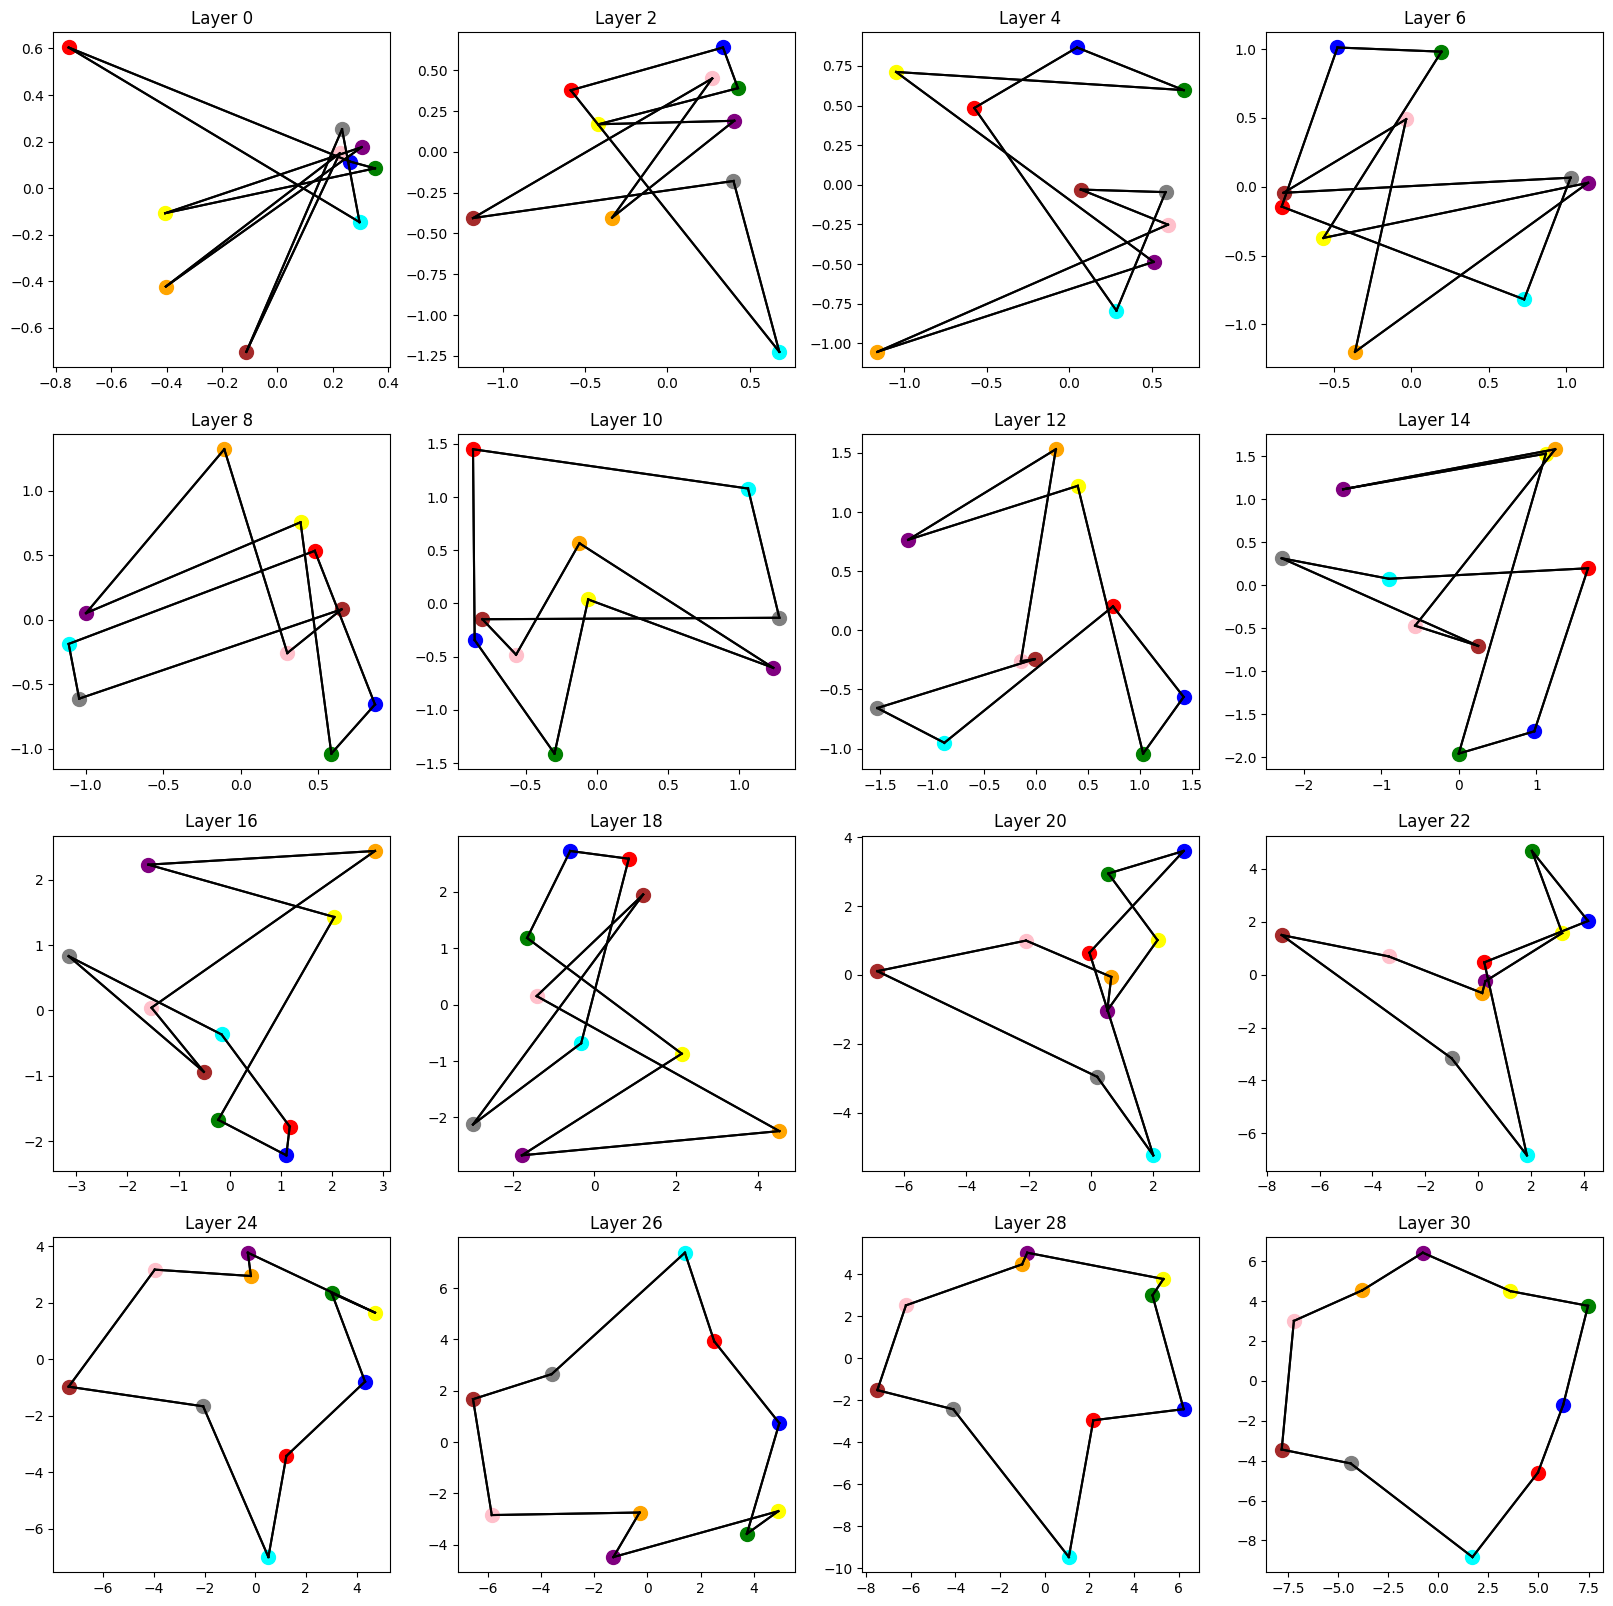

In [13]:

acts = torch.load(os.path.join(exp_dir, "activations.pt"))

window_size = 200
component_1 = 1
component_2 = 2
plot_3d_pca.main(
    config["exp_dir"],
    model.tokenizer,
    n_examples,
    window_size,
    component_1,
    component_2,
)

In [14]:


rule_accs = torch.load(os.path.join(exp_dir, "rule_accs.pt"))
data = torch.load(os.path.join(exp_dir, "data.pt"))

adjacency_matrix = dgp.transition_matrix > 0

/tmp/ipykernel_1442103/2207936486.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rule_accs = torch.load(os.path.join(exp_dir, "rule_accs.pt"))
/tmp/ipykernel_1442103/22

In [15]:

seq_locs = list(range(1, n_examples, 10))
class_mean_activations = []
for seq_loc in seq_locs:
    class_mean_activation = utils.get_class_mean_activations(
        acts, seq_loc=seq_loc, word_masks=data["word_masks"], window_size=20
    )  # 200)
    class_mean_activations.append(class_mean_activation)
class_mean_activations = torch.stack(class_mean_activations)
print(class_mean_activations.shape)

torch.Size([40, 16, 10, 4096])


In [16]:

energies = []
for class_mean_activation in class_mean_activations:
    for layer_activation in class_mean_activation:
        layer_activation_ = layer_activation.clone()
        norms = layer_activation_.norm(dim=(0, 1), keepdim=True)
        layer_activation_ /= norms
        sqdiffs = (
            (layer_activation_[None, :, :] - layer_activation_[:, None, :]) ** 2
        ).mean(-1)
        energy = (0.5 * adjacency_matrix * sqdiffs).sum()

        energies.append(energy)
energies = torch.stack(energies).reshape(len(seq_locs), -1)
print(energies.shape)

torch.Size([40, 16])


<Figure size 2000x500 with 0 Axes>

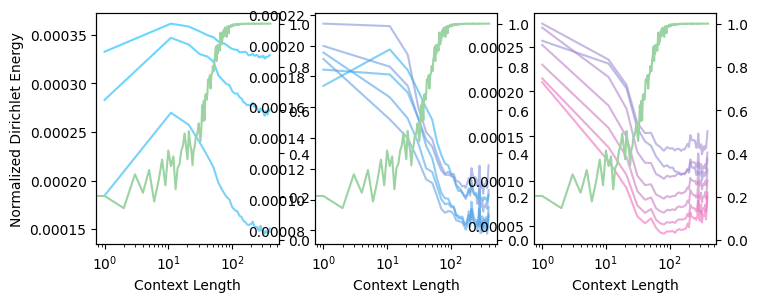

In [17]:


color_1 = np.array([255, 105, 180, 0.6 * 255]) / 255
color_2 = np.array([0, 191, 255, 0.6 * 255]) / 255
green = "#9CD3A3"

plt.figure(figsize=(20, 5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

ax1.set_xlabel("Context Length")
ax1.set_ylabel("Normalized Dirichlet Energy")

n_curves = 16
for i_layer in range(3):
    _color = (i_layer / n_curves) * color_1 + (1 - i_layer / n_curves) * color_2
    ax1.plot(seq_locs, energies[:, i_layer], color=_color)
plt.xscale("log")
ax1_2 = ax1.twinx()
ax1_2.plot(rule_accs.mean(0), color=green, label="Accuracy")


ax2.set_xlabel("Context Length")
# ax2.set_ylabel("Normalized Dirichlet Energy")
for i_layer in range(3, 9):
    _color = (i_layer / n_curves) * color_1 + (1 - i_layer / n_curves) * color_2
    ax2.plot(seq_locs, energies[:, i_layer], color=_color)
plt.xscale("log")
ax2_2 = ax2.twinx()
ax2_2.plot(rule_accs.mean(0), color=green, label="Accuracy")

ax3.set_xlabel("Context Length")
# ax3.set_ylabel("Normalized Dirichlet Energy")
for i_layer in range(9, energies.shape[1]):
    _color = (i_layer / n_curves) * color_1 + (1 - i_layer / n_curves) * color_2
    ax3.plot(seq_locs, energies[:, i_layer], color=_color)
plt.xscale("log")
ax3_2 = ax3.twinx()
ax3_2.plot(rule_accs.mean(0), color=green, label="Accuracy")

plt.savefig(os.path.join(exp_dir, "energy_vs_acc.pdf"))
